<a id='top'></a>
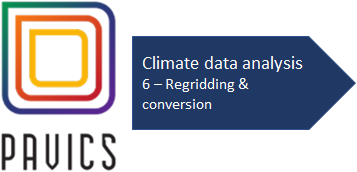

When data PAVICS analysis is complete users may often wish to to export final results to other formats in order to be used with packages (GIS or statiscal software). <br>
This tutorial outlines steps for:

* [Regridding and exporting mapping data to GIS compatible formats](#regrid_geotiff)
* [Converting to tabular formats](#timeseries)


<div class="alert alert-info"> <strong>Info!</strong> This notebook accesses files created in tutorial 5. Be sure to run the <strong>Advanced visualization</strong> tutorial before beginning.
</div>
<div class="alert alert-info">
To conserve any modifications to tutorial notebooks in the PAVICS JupyterLab they need to be copied into your <a href=#workspace>writable-workspace</a> directory.    
</div>

<a id='regrid_geotiff'></a>
## Regridding and export of raster data

We will reuse of mapping data from the previous tutorial and perform a regridding operation then export the data in GIS raster format 

Addtional steps:
* Use the <a href="https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html" target="_blank">**xesmf**</a> package to regrid our *rotated pole* data to a regular latitude/ longitude grid
* Use <a href="https://corteva.github.io/rioxarray/stable/" target="_blank">**rioxarray**</a> to convert to Geotiff format


*[return to top of page](#top)*

In [1]:
# NBVAL_IGNORE_OUTPUT
import logging
import warnings
from pathlib import Path

import hvplot.xarray
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import xesmf as xe
import xscen as xs
from cartopy import crs as ccrs
from clisops.core import subset
from IPython.display import clear_output
from xclim import ensembles as xens
from xclim.core import units

logging.getLogger().disabled = True
warnings.simplefilter("ignore")

clear_output()


* Use the `xesmf` to regrid the **ESPO-G6-R2** data to a regular lat/lon grid using conservative normal interpolation (we will want to ensure that we regrid using a <a href="https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html#Regridding-with-a-mask" target="_blank">**mask**</a>)
* Create a target output grid of 0.1 x 0.1 degree resolution


In [2]:
ncfile = Path(
    "/notebook_dir/writable-workspace/tmp/tutorial5/output/Gaspesie_ESPO-G6-R2_30yAvg_ensemble_percentiles.nc"
)
ds30yAvg_ensfill = xr.open_dataset(ncfile, chunks={}, decode_timedelta=False)
ds30yAvg_ensfill = ds30yAvg_ensfill.assign_coords(
    **xs.regrid.create_bounds_rotated_pole(ds30yAvg_ensfill)
)

# compare regridded to original
rotp = ccrs.RotatedPole(
    pole_longitude=ds30yAvg_ensfill.rotated_pole.grid_north_pole_longitude,
    pole_latitude=ds30yAvg_ensfill.rotated_pole.grid_north_pole_latitude,
)
## create a mask using the extent of the data itself
dict_sel = dict(time="2071", scen="ssp245", season="annual", percentiles=50)
ds30yAvg_ensfill["mask"] = ~np.isnan(ds30yAvg_ensfill.tx_mean.sel(dict_sel).squeeze())

# create the output target grid
cell_res = 0.1
lon0, lon1 = (
    ds30yAvg_ensfill.lon.min().values - cell_res,
    ds30yAvg_ensfill.lon.max().values + cell_res,
)
lat0, lat1 = (
    ds30yAvg_ensfill.lat.min().values - cell_res,
    ds30yAvg_ensfill.lat.max().values + cell_res,
)
outgrid = xe.util.cf_grid_2d(lon0, lon1, cell_res, lat0, lat1, cell_res)

# Create xesmf regridder object
regridder = xe.Regridder(
    ds30yAvg_ensfill, outgrid, "conservative_normed", unmapped_to_nan=True
)
# Apply regridding
ds30yAvg_ensregrid = regridder(ds30yAvg_ensfill)

# compare
ds30yAvg_ensfill.sel(dict_sel).tx_days_above_27.hvplot.quadmesh(
    title="Original : Rotated pole",
    x="rlon",
    y="rlat",
    crs=rotp,
    geo=True,
    cmap="spectral_r",
    tiles="EsriImagery",
    alpha=0.95,
) + ds30yAvg_ensregrid.sel(dict_sel).tx_days_above_27.hvplot.quadmesh(
    title="Regridded : Regular lon/lat",
    x="lon",
    y="lat",
    geo=True,
    xlim=[-68, -63.5],
    cmap="spectral_r",
    tiles="EsriImagery",
    alpha=0.95,
)

:Layout
   .DynamicMap.I  :DynamicMap   [time]
      :Overlay
         .WMTS.I     :WMTS   [Longitude,Latitude]
         .QuadMesh.I :QuadMesh   [rlon,rlat]   (tx_days_above_27)
   .DynamicMap.II :DynamicMap   [time]
      :Overlay
         .WMTS.I     :WMTS   [Longitude,Latitude]
         .QuadMesh.I :QuadMesh   [lon,lat]   (tx_days_above_27)


* Use <a href="https://corteva.github.io/rioxarray/stable/" target="_blank">**rioxarray**</a> to convert to Geotiff format
* Loop over dimensions and export multidimensional data to a series of `geotiff` files

In [3]:
display(list(ds30yAvg_ensregrid.dims))

for vv in [
    v for v in ds30yAvg_ensregrid.data_vars if "time" in ds30yAvg_ensregrid[v].dims
]:
    for tt in ds30yAvg_ensregrid.time:
        for ss in ds30yAvg_ensregrid.scen.values:
            for seas in ds30yAvg_ensregrid.season.values:
                for pp in ds30yAvg_ensregrid.percentiles.values:
                    data = (
                        ds30yAvg_ensregrid[vv]
                        .sel(time=tt, scen=ss, season=seas, percentiles=pp)
                        .squeeze()
                    )

                    data = data.rio.set_crs("epsg:4326").rio.set_spatial_dims(
                        x_dim="lon", y_dim="lat"
                    )
                    outtiff = Path(
                        f"/notebook_dir/writable-workspace/tmp/tutorial6/geotiff/{vv}/ESPO-G6-R2v1.0_{vv}_{data.horizon.values}_{ss}_{seas}_p{pp}.tiff"
                    )
                    outtiff.parent.mkdir(parents=True, exist_ok=True)
                    data.rio.to_raster(outtiff)

print("Geotiffs written to  writable-workspace/tmp/tutorial6 folder")

['time', 'scen', 'season', 'percentiles', 'lat', 'lon']

Geotiffs written to  writable-workspace/tmp/tutorial6 folder


<a id='timeseries'></a>
## Exporting to tabluar data format
* xarray allows very simple conversion and export to formats such as `CSV` via `to_dataframe` or `to_dask_dataframe` methods.
* Here we subset two locations of a single **ESPO-G6-R2** simulation and export the daily values to a .csv file.

<div class="alert alert-warning"> <strong>Info!</strong> With larger amounts of data please use <code>xr.Dataset.to_dask_dataframe</code> to avoid loading all values into memory.
</div>

*[return to top of page](#top)*

In [4]:
from dask.diagnostics import ProgressBar

# With larger datasets it is preferabble to use 'dask_daskframe' to avoid loading all data to memory
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/ouranos/ESPO-G/ESPO-G6-R2v1.0.0/day_ESPO-G6-R2_v1.0.0_CMIP6_ScenarioMIP_NAM_MPI-M_MPI-ESM1-2-LR_ssp370_r1i1p1f1_19500101-21001231.ncml"
lonpt = [-74, -80]
latpt = [45, 42]
ds_big = subset.subset_gridpoint(
    xr.open_dataset(url, chunks=dict(time=365 * 8, rlon=50, rlat=50)),
    lon=lonpt,
    lat=latpt,
)
display(ds_big)

# convert to dask dataframe
ddf = ds_big.to_dask_dataframe()

# export to .csv file
outfile = Path(
    f"/notebook_dir/writable-workspace/tmp/tutorial6/csv/test_daily_export.csv"
)
outfile.parent.mkdir(exist_ok=True, parents=True)
with ProgressBar():
    ddf.to_csv(outfile, single_file=True)
print("CSV file written to  writable-workspace/tmp/tutorial6 folder")

<xarray.Dataset>
Dimensions:       (site: 2, time: 55115)
Coordinates:
    rlat          (site) float32 -11.43 -15.39
    rlon          (site) float32 373.2 369.5
    rotated_pole  float32 9.969e+36
  * time          (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
    lat           (site) float32 45.0 41.98
    lon           (site) float32 -73.95 -80.03
Dimensions without coordinates: site
Data variables:
    lakeFrac      (site) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sftlf         (site) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sftof         (site) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    tasmin        (site, time) float32 dask.array<chunksize=(1, 2920), meta=np.ndarray>
    tasmax        (site, time) float32 dask.array<chunksize=(1, 2920), meta=np.ndarray>
    pr            (site, time) float32 dask.array<chunksize=(1, 2920), meta=np.ndarray>
Attributes: (12/79)
    Conventions:                     CF-1.8
    Notes:                           Created from the Gem_geophy.fst file pro...
    doi:                             https://doi.org/10.1038/s41597-023-02855-z
    frequency:                       fx
    institution:                     Ouranos Consortium on Regional Climatolo...
    licence_type:                    open
    ...                              ...
    bias_adjust_reference_citation:  https://doi.org/10.5194/hess-25-4917-2021
    license_type:                    permissive
    terms_of_use:                    In addition to the provided licence, the...
    attribution:                     Use of this dataset should be acknowledg...
    modeling_realm:                  atmos
    source_institution:              MPI-M

[########################################] | 100% Completed | 69.06 ss
CSV file written to  writable-workspace/tmp/tutorial6 folder


___
### Notes
<a id='notes'></a>

<a id='workspace'></a>

<div class="alert alert-info"><strong>Info! writeable-workspace location.</strong> To conserve any modifications and to avoid permission errors for notebooks which write output to disk it is necessary to copy tutorial notebooks from the "pavics-homepage" folder to a location within your "writeable-workspace"
</div>

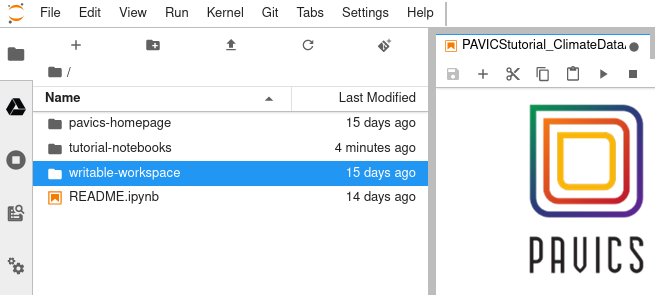

*[return to top of page](#top)*